In [510]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

from src.IterativeFitting import IterativeFitting as IF
from src.CorrFuncs import covariance_matrix, trend_est

In [519]:
# Initializing simulation slope and intercept parameters
beta0 = -0.1
beta1 = 0.02
beta_age = 0.05
beta_income = -0.05
beta_sex = 1.0

# Number of samples
n = 40000

# Constructing covariate vectors for additional covariates to adjust
age_vector = np.random.uniform(low=0,high=1,size=n)
income_vector = np.random.uniform(low=0,high=1,size=n)
sex_vector = np.random.binomial(n=1,p=0.6,size=n)

# Generating plausible x values to throw into probability generator
xs = np.sort(np.random.uniform(low=0,high=20,size=n))

# Getting quantiles of sorted xs
quantile_indices = np.array([n//4, n//2, 3*n//4])

# Getting exposure levels (randomly chosen from quantile ranges)
exposure_levels = [np.random.choice(xs[:quantile_indices[0]])]
for i in range(1,len(quantile_indices)):
    exposure_levels.append(np.random.choice(xs[quantile_indices[i-1]:quantile_indices[i]]))
exposure_levels.append(np.random.choice(xs[quantile_indices[-1]:]))
exposure_indices = np.array([np.where(xs == elem)[0][0] for elem in exposure_levels])

# Function to generate probabilities of being a case v non-case
other_covs = beta0 + (beta_age*age_vector) + (income_vector*beta_income) + (sex_vector*beta_sex) 
p = lambda x: (np.exp(beta1*x + other_covs))/(1 + np.exp(beta1*x + other_covs))

# Actually calculating probabilities on exposures as defined
px = p(xs)

# Actually assigning to case or not
outcomes = np.array([np.random.binomial(n=1,p=p,size=1)[0] for p in px])

# Constructing and sorting dataframe of outcomes and exposure
df = np.stack([outcomes,xs],axis=1)
df = df[np.argsort(df[:, 1])]

# Getting xs corresponding to each exposure interval
categories = [df[:exposure_indices[0]]]
for i in range(1,len(exposure_indices)):
    categories.append(df[exposure_indices[i-1]:exposure_indices[i]])
categories.append(df[exposure_indices[-1]:])

# Getting case numbers
cases = np.array([np.sum(df[:,0]) for df in categories])
N = np.array([df.shape[0] for df in categories])
non_cases = N - cases
M = np.sum(cases)
a_0, A = cases[0], cases[1:]
b_0, B = non_cases[0], non_cases[1:]

# Getting crude estimates to compare
crude = lambda x,y: (x/y) / (a_0/b_0)
crudeors = crude(A,B)

# Constructing dummy variables with respect to exposure level
dummy_list = []
for i in range(1,len(exposure_indices)):
    exp_cat = np.zeros(n)
    exp_cat[exposure_indices[i-1]:exposure_indices[i]] = 1
    dummy_list.append(exp_cat)
last_cat = np.zeros(n)
last_cat[exposure_indices[-1]:] = 1
dummy_list.append(last_cat)

# Getting regression matrix
to_adjust_matrix = np.column_stack([np.ones(n), age_vector, income_vector, sex_vector] + dummy_list)

# Performing logit
cols = ["intercept", "age", "income", "sex"]
cols += ["exposure_" + str(i+1) for i in range(len(exposure_levels))]
to_adjust_df = pd.DataFrame(to_adjust_matrix, columns=cols)

results = sm.Logit(endog=df[:,0], exog=to_adjust_df).fit()
true_C = results.cov_params().to_numpy()[4:,4:]
true_C_inv = np.linalg.inv(true_C)

# Get log-ORs and corresponding variances
L = results.params.to_numpy()[4:]
v = (results.bse.to_numpy()[4:])**2

Optimization terminated successfully.
         Current function value: 0.614559
         Iterations 5


In [520]:
# Running GL
it_fit_ex = IF(L,A,N,M)
Ap, Bp, a0p, b0p = it_fit_ex.convexProgram()

C = covariance_matrix(Ap,Bp,a0p,b0p,v)
inv_C = np.linalg.inv(C)

In [521]:
# Recovering slope estimate for corrected correlation
x = np.array(exposure_levels)
vb_star = 1/(np.dot(x,np.dot(inv_C,x)))
b_star = vb_star*(np.dot(x,np.dot(inv_C,L)))

In [522]:
b_star

0.01930133765234124

In [523]:
# Recovering standard slope estimate
vb = 1/(np.dot(x,np.dot(np.linalg.inv(np.diag(v)),x)))
b = vb*(np.dot(x,np.dot(np.linalg.inv(np.diag(v)),L)))

In [524]:
b

0.025396143273001465

In [525]:
vb_oracle = 1/(np.dot(x,np.dot(true_C_inv,x)))
b_oracle = vb_oracle*(np.dot(x,np.dot(true_C_inv,L)))
b_oracle

0.019275479447535014

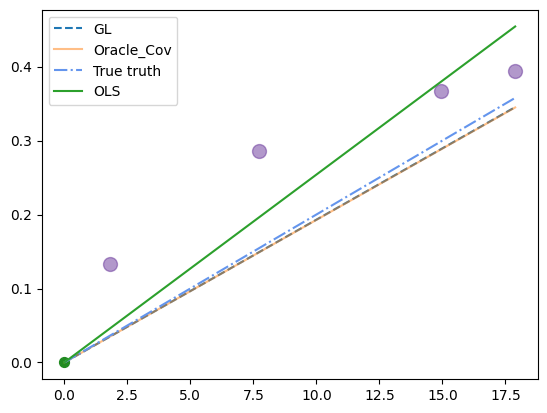

In [526]:
x_valsp = np.hstack([0,x])
plt.scatter(x,L,alpha=0.5,c="rebeccapurple",s=100)
plt.scatter(0,0,s=50,c="forestgreen")
plt.plot(x_valsp,b_star*x_valsp,label = 'GL',linestyle = 'dashed')
plt.plot(x_valsp,b_oracle*x_valsp,label = 'Oracle_Cov', alpha = 0.5)
plt.plot(x_valsp,beta1*x_valsp,label = 'True truth',c="cornflowerblue",linestyle="dashdot")
plt.plot(x_valsp,b*x_valsp,label = "OLS")
plt.legend()

In [330]:
true_C

array([[0.00306147, 0.00261319, 0.0026142 , 0.00261532],
       [0.00261319, 0.00319839, 0.00261857, 0.00262105],
       [0.0026142 , 0.00261857, 0.00328982, 0.00262534],
       [0.00261532, 0.00262105, 0.00262534, 0.00751937]])

In [331]:
C

array([[0.00306147, 0.00260615, 0.00260023, 0.00254178],
       [0.00260615, 0.00319839, 0.00259679, 0.00253842],
       [0.00260023, 0.00259679, 0.00328982, 0.00253265],
       [0.00254178, 0.00253842, 0.00253265, 0.00751937]])